In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from functools import reduce
import qutip
from tqdm import tqdm
import cmath
from threadpoolctl import threadpool_limits
import itertools
from multiprocessing import Pool

In [2]:
class Basis:
    def __init__(self, spin_g, spin_e, spin_m, spin_nuc, num_nuc):
        """
        spin_g: elec spin of ground state
        spin_e: elec spin of excited state 
        spin_m: elec spin of metastable state 
        nuc_spin: nuclear spin (assume all equal)
        num_nuc: number of nuclear spins
        """
        self.spin_g = spin_g
        self.spin_e = spin_e
        self.spin_m = spin_m
        self.spin_nuc = spin_nuc
        self.num_g = int(2*spin_g+1)
        self.basis_g = np.eye(self.num_g)
        self.num_e = int(2*spin_e+1)
        self.basis_e = np.eye(self.num_e)
        self.num_m = int(2*spin_m+1)
        self.basis_m = np.eye(self.num_m)
        self.num_nuc = num_nuc
        self.num_nuc_one = (int(2*spin_nuc+1))
        self.basis_nuc = np.eye(self.num_nuc_one)
        self.num_nuc_sub = self.num_nuc_one**num_nuc
        self.elec_spins_g = np.arange(-spin_g,spin_g+1,1)
        self.basis_g = np.eye(self.num_g)
        self.elec_spins_e = np.arange(-spin_e,spin_e+1,1)
        self.elec_spins_m = np.arange(-spin_m,spin_m+1,1)
        self.nuc_spins = np.arange(-self.spin_nuc,self.spin_nuc+1,1)
        self.dim_g = self.num_nuc_sub*self.num_g
        self.dim_e = self.num_nuc_sub*self.num_e
        self.dim_m = self.num_nuc_sub*self.num_m
        
    def state(self, elec_spin, nuc_spins):
        """
        Input: level (excited, ground, or metastable), electron spin, and array of nuclear spins
        """
        if len(nuc_spins) != self.num_nuc:
            raise Exception("Need valid number of nuclei")
        for i in range(self.num_nuc):
            if nuc_spins[i] not in self.nuc_spins:
                raise Exception("Need valid nuclear spins")
        if level == 'g':
            if elec_spin in self.elec_spins_g:
                all_states = [self.basis_g[int(-elec_spin+self.spin_g)]]
                for ns in nuc_spins:
                    all_states.append(self.basis_nuc[int(-ns+self.spin_nuc)])
                return np.append(reduce(np.kron, all_states),np.zeros(self.dim_e+self.dim_m))
            else:
                raise Exception("Need valid spin")
        elif level == 'e':
            if elec_spin in self.elec_spins_e:
                all_states = [self.basis_e[int(-elec_spin+self.spin_e)]]
                for ns in nuc_spins:
                    all_states.append(self.basis_nuc[int(-ns+self.spin_nuc)])
                return np.append(np.zeros(self.dim_g),np.append(reduce(np.kron, all_states),np.zeros(self.dim_m)))
            else:
                raise Exception("Need valid spin")
        elif level == 'm':
            if elec_spin in self.elec_spins_m:
                all_states = [self.basis_m[int(-elec_spin+self.spin_m)]]
                for ns in nuc_spins:
                    all_states.append(self.basis_nuc[int(-ns+self.spin_nuc)])
                return np.append(np.zeros(self.dim_g+self.dim_e),reduce(np.kron, all_states))
            else:
                raise Exception("Need valid spin")
        else:
            raise Exception("Need valid level")

In [3]:
def spin_matrix(s, axis):
    """
    Input: total spin and axis (x,y,z)
    Output: corresponding spin matrix
    """
    dim = int(2*s+1)
    result = np.zeros((dim,dim), dtype='complex')
    if axis == 'x':
        entry = lambda i, j: (1/2)*(np.eye(dim+2)[i,j+1]+np.eye(dim+2)[i+1,j])*cmath.sqrt((s+1)*(i+j-1)-i*j)
    elif axis == 'y':
        entry = lambda i, j: (1j/2)*(np.eye(dim+2)[i,j+1]-np.eye(dim+2)[i+1,j])*cmath.sqrt((s+1)*(i+j-1)-i*j)
    elif axis == 'z':
        entry = lambda i, j: (s+1-i)*np.eye(dim+2)[i,j]
    else:
        raise Exception("Need valid axis (x,y, or z)")
        
    for i in range(dim):
        for j in range(dim):
            result[i,j] = entry(i+1,j+1)
    return result

In [4]:
def rotation_matrix(angle, axis, elec_spin, dim_nuc):
    """
    Input: rotation angle (radians), axis (3-vector), electron spin, and remaining dimension 
    Output: rotation matrix that acts on electron and keeps nuclear same
    """
    
    return np.kron(scipy.linalg.expm(-1j*angle*(axis[0]*spin_matrix(elec_spin, 'x')+axis[1]*spin_matrix(elec_spin, 'y')+axis[2]*spin_matrix(elec_spin, 'z'))), np.eye(dim_nuc))



In [5]:
class Simple_Basis:
    """
    Simple Fock basis
    """
    def __init__(self, num_of_states):
        self.basis = np.eye(int(num_of_states))
    def state(self, level):
        return self.basis[level]

In [6]:
class Basis_g:
    def __init__(self, spin_g, spin_nuc, num_nuc):
        """
        spin_g: elec spin of ground state 
        nuc_spin: nuclear spin (assume all equal)
        num_nuc: number of nuclear spins
        """
        self.spin_g = spin_g
        self.spin_nuc = spin_nuc
        self.num_g = int(2*spin_g+1)
        self.basis_g = np.eye(self.num_g)
        self.num_nuc = num_nuc
        self.num_nuc_one = (int(2*spin_nuc+1))
        self.basis_nuc = np.eye(self.num_nuc_one)
        self.num_nuc_sub = self.num_nuc_one**num_nuc
        self.elec_spins_g = np.arange(-spin_g,spin_g+1,1)
        self.basis_g = np.eye(self.num_g)
        self.nuc_spins = np.arange(-self.spin_nuc,self.spin_nuc+1,1)
        self.dim_g = self.num_nuc_sub*self.num_g
        
    def state(self, level, elec_spin, nuc_spins):
        """
        Input: level (excited, ground, or metastable), electron spin, and array of nuclear spins
        """
        if len(nuc_spins) != self.num_nuc:
            raise Exception("Need valid number of nuclei")
        for i in range(self.num_nuc):
            if nuc_spins[i] not in self.nuc_spins:
                raise Exception("Need valid nuclear spins")
        if elec_spin in self.elec_spins_g:
            all_states = [self.basis_g[int(-elec_spin+self.spin_g)]]
            for ns in nuc_spins:
                all_states.append(self.basis_nuc[int(-ns+self.spin_nuc)])
            return np.append(reduce(np.kron, all_states),np.zeros(self.dim_e+self.dim_m))
        else:
            raise Exception("Need valid spin")

100%|███████████████████████████████████████████| 40/40 [00:08<00:00,  4.52it/s]


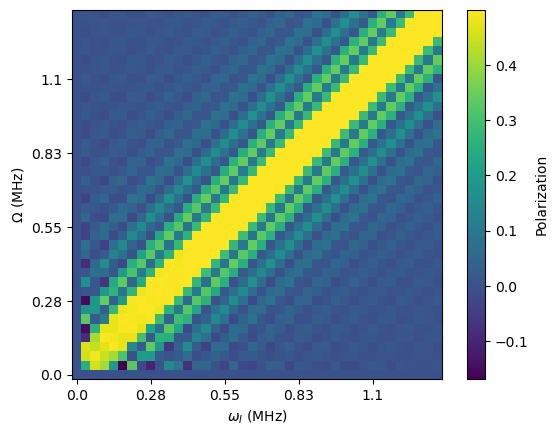

In [711]:
#implement NOVEL spin-locking sequence

#toy model: spin 1/2 electron, spin 1/2 nucleus (should be carbon, but let's try first with nitrogen)

#|0> is (1,0)

spin_elec = 1/2
spin_nuc = 1/2
dim_elec = int(2*spin_elec+1)
dim_nuc = int(2*spin_nuc+1)

simple_basis = Simple_Basis(dim_elec)

#start with electron in ground state and spin maximally mixed
rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.eye(dim_nuc))/dim_nuc

U1 = rotation_matrix(np.pi/2, (0,1,0), spin_elec, dim_nuc)

#spin operators
S_x = np.kron(spin_matrix(spin_elec, 'x'),np.eye(dim_nuc))
S_y = np.kron(spin_matrix(spin_elec, 'y'),np.eye(dim_nuc))
S_z = np.kron(spin_matrix(spin_elec, 'z'),np.eye(dim_nuc))

I_x = np.kron(np.eye(dim_elec), spin_matrix(spin_nuc, 'x'))
I_y = np.kron(np.eye(dim_elec), spin_matrix(spin_nuc, 'y'))
I_z = np.kron(np.eye(dim_elec), spin_matrix(spin_nuc, 'z'))

gyro_e = 2*np.pi*2.8025e6 #Hz/G
gyro_C13 = 2*np.pi*10.7e2 #Hz/G

A_par = 30e3
A_perp = 40e3

#toy model Hamiltonian
def H(Omega, B):
    """
    Input: spin-lock amplitude (scalar) and magnetic field (3-scalar)
    Output: Hamiltonian matrix
    """
    H = (gyro_C13*(B[0]*I_x+B[1]*I_y+B[2]*I_z)+
        A_par*S_z@I_z + A_perp*S_z@I_x+Omega*S_x)
    return H

t = 50e-6 #test different values, but order of -6 to be >> than A_perp, etc (see paper)
#t_array = (np.pi/np.linspace(0.001,0.5,50))*1e-6

B_array = np.array([[0,0,i] for i in np.linspace(0,200, 40)]) #applied magnetic field
Bz_array = B_array[:,-1]
Omega_array = gyro_C13*np.linspace(0.001,Bz_array[-1],40) #Rabi drive frequency
omega_I_array = Bz_array*gyro_C13 #nuclear Larmor frequency
U3 = U1
N = 100

pol = []
for Omega in tqdm(Omega_array):
    pol.append([])
    for B in B_array:
        rho = rho_0
        for i in range(N):
            U2 = scipy.linalg.expm(-1j*H(Omega, B)*t) #time evolution operator
            temp = U3@U2@U1@rho@((U1.T).conjugate())@((U2.T).conjugate())@((U3.T).conjugate())
            rho_I = np.trace(temp.reshape(dim_elec,dim_nuc,dim_elec,dim_nuc), axis1=0, axis2=2) #traced out nuclear density matrix
            rho = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), rho_I) #reinitialize electron spin to |0>
        pol[-1].append(np.real(np.trace(I_z@rho)))
    #plt.plot(np.arange(len(pol)), pol, label=r"$\Omega=$ "+str(np.round(Omega/1e6,2))+"MHz")
pol = np.array(pol)
plt.imshow(pol,origin='lower')
plt.xlabel(r"$\omega_I$ (MHz)")
plt.ylabel(r"$\Omega$ (MHz)")
plt.xticks(np.arange(len(Bz_array), step=int(len(Bz_array)/5)),np.round(Bz_array[0::int(len(Bz_array)/5)]*gyro_C13/1e6,2))
plt.yticks(np.arange(len(Omega_array), step=int(len(Omega_array)/5)),np.round(Omega_array[0::int(len(Omega_array)/5)]/1e6,2))
plt.colorbar(label="Polarization")
plt.show()

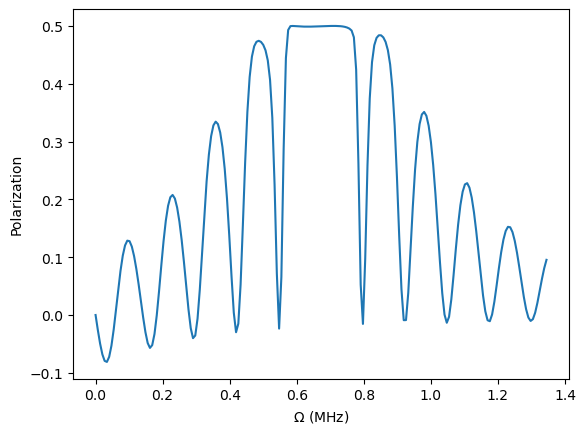

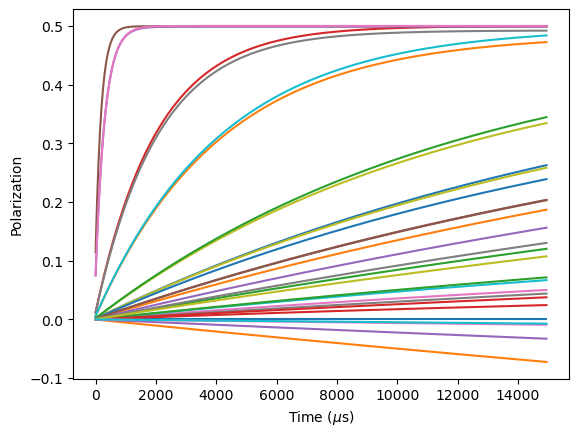

In [245]:
#plot polarization as a function of Rabi drive and time 

B = (0,0,100)
t = 50e-6
N=300
Omega_array = gyro_C13*np.linspace(0.001,2*B[-1],200)
pol = []
pol_with_time = []
for Omega in Omega_array:
    pol_with_time.append([])
    rho = rho_0
    for i in range(N):
        U2 = scipy.linalg.expm(-1j*H(Omega, B)*t) #note the /2 for the rNOVEL sequence
        temp = U3@U2@U1@rho@((U1.T).conjugate())@((U2.T).conjugate())@((U3.T).conjugate())
        rho_I = np.trace(temp.reshape(dim_elec,dim_nuc,dim_elec,dim_nuc), axis1=0, axis2=2)
        rho = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), rho_I)
        pol_with_time[-1].append(np.real(np.trace(I_z@rho)))
    pol.append(np.real(np.trace(I_z@rho)))
    #plt.plot(np.arange(len(pol)), pol, label=r"$\Omega=$ "+str(np.round(Omega/1e6,2))+"MHz")

plt.plot(Omega_array/1e6, pol)
plt.xlabel(r"$\Omega$ (MHz)")
plt.ylabel(r"Polarization")
plt.show()

num_plots = 30
for i in range(num_plots):
    plt.plot(np.arange(len(pol_with_time[0]))*t/1e-6, pol_with_time[int(len(pol_with_time)/num_plots*i)])

plt.xlabel(r"Time ($\mu$s)")
plt.ylabel(r"Polarization")
plt.show()
#plt.legend()

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.08s. Est. time left: 00:00:00:00
40.0%. Run time:   0.09s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
70.0%. Run time:   0.12s. Est. time left: 00:00:00:00
80.0%. Run time:   0.13s. Est. time left: 00:00:00:00
90.0%. Run time:   0.13s. Est. time left: 00:00:00:00
100.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.14s


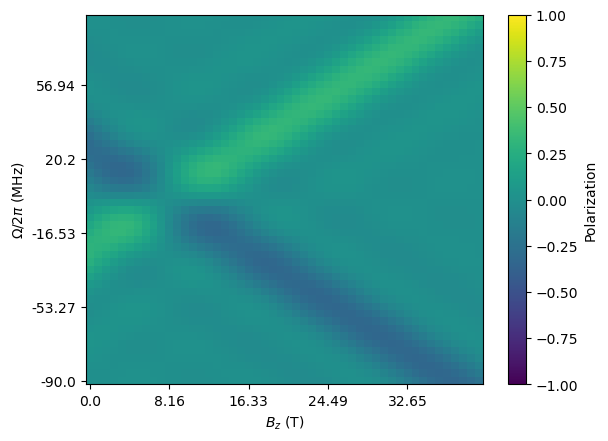

Omega: 542405588.762646
Bz: 359183.67346938775


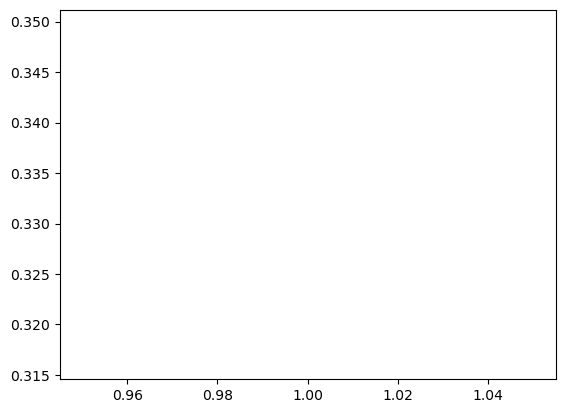

[0.33287834435505903]
0.33287834435505903


<Figure size 640x480 with 0 Axes>

In [23]:
#implement NOVEL spin-locking sequence
"""
first model: focus on ground state (since there's no green 
             laser excitation) of hBN and consider only three 
             nearest nitrogen neighbors. Simulate same as before 
             but with Hamiltonian from equation A9 in the paper: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.107.214307
             Neglect spin-spin interaction for now
             Consider full hyperfine tensor for hBN ground state
             Change spin operators for effective two level system consisting of |0> 
             and |-1>, since this is the transition we choose to drive (why not |0> and |+1>, since working at high fields)
"""

spin_elec = 1/2
spin_g = spin_elec
spin_nuc = 1/2
num_nuc = 3
dim_elec = int(2*spin_elec+1)
dim_nuc = int(2*spin_nuc+1)**num_nuc

simple_basis = Simple_Basis(dim_elec)

#start with electron in ground state and spin maximally mixed

U1 = rotation_matrix(np.pi/2, (0,1,0), spin_elec, dim_nuc)

gyro_e = 2*np.pi*2.8025e6 #Hz/G

isotope = False

basis = Basis_g(spin_elec, spin_nuc, num_nuc)

num_g = basis.num_g #number of spin sublevels in ground state
num_nuc_one = basis.num_nuc_one
num_nuc_sub = basis.num_nuc_sub #number of sublevels due to hyperfine splitting
dim_g = basis.dim_g #ground states

nuc_spins = basis.nuc_spins
elec_spins_g = basis.elec_spins_g

all_nuc_spins = list(itertools.product(*np.repeat([nuc_spins],num_nuc,axis=0)))
# 2. define hamiltonian
"""
Keep excited and metastable state out for now
"""

#operators for ground state.
S_x_g = scipy.linalg.block_diag(np.kron(spin_matrix(spin_g, 'x'),np.eye(num_nuc_sub)))
S_y_g = scipy.linalg.block_diag(np.kron(spin_matrix(spin_g, 'y'),np.eye(num_nuc_sub)))
S_z_g = scipy.linalg.block_diag(np.kron(spin_matrix(spin_g, 'z'),np.eye(num_nuc_sub)))

I_x_g = []
I_y_g = []
I_z_g = []


for i in range(num_nuc):
    temp = np.repeat([np.eye(num_nuc_one)], num_nuc+1, axis=0).tolist()
    temp[0] = np.eye(num_g)
    
    temp[i+1] = spin_matrix(spin_nuc, 'x')
    I_x_g.append(scipy.linalg.block_diag(reduce(np.kron, temp)))

    temp[i+1] = spin_matrix(spin_nuc, 'y') 
    I_y_g.append(scipy.linalg.block_diag(reduce(np.kron, temp)))

    temp[i+1] = spin_matrix(spin_nuc, 'z')
    I_z_g.append(scipy.linalg.block_diag(reduce(np.kron, temp)))

I_x_g = np.array(I_x_g)    
I_y_g = np.array(I_y_g)
I_z_g = np.array(I_z_g)

factor_hyp = 1
if isotope == False:  
    D_g = 2*np.pi*3.47e9  
    gyro_14N = 2*np.pi*0.3077e3
    Q = 2*np.pi*383e3  #science paper
    #Q = -1.58e6
    
    Axx_g = 2*np.pi*np.array([47e6, 79e6, 79e6])/factor_hyp   #equalizes secondary resonance peaks mmore
    Ayy_g = 2*np.pi*np.array([47e6, 58e6, 58e6])/factor_hyp  #creates sort of modulation along y=x line
    Azz_g = 2*np.pi*np.array([48e6, 48e6, 48e6])/factor_hyp
    Axy_g = 2*np.pi*np.array([0, -18e6, 18e6])/factor_hyp
    Azx_g = -(1/2)*2*np.pi*np.array([48e6, 48e6, 48e6])/factor_hyp #acts as effective Rabi oscillation for nuclear spins, so allows for polarization transfer (hyperfine interaction oscillates nuclei!!)
    Azy_g = -(1/2)*2*np.pi*np.array([48e6, 48e6, 48e6])/factor_hyp
    Axz_g = 2*np.pi*np.array([0, 0, 0])/factor_hyp

else:
    D_g = 2*np.pi*3.47e9  
    gyro_14N = -2*np.pi*0.432e3
    Q = 0
    Axx_g = 2*np.pi*np.array([-66e6, -111e6, -111e6])/factor_hyp
    Ayy_g = 2*np.pi*np.array([-126e6, -81e6, -81e6])/factor_hyp
    Azz_g = 2*np.pi*np.array([-66e6, -66e6, -66e6])/factor_hyp
    Axy_g = 2*np.pi*np.array([0, 26e6, -26e6])/factor_hyp
#operators for excited state

"""
S_x_e = scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), np.kron(spin_matrix(spin_e, 'x'),np.eye(num_nuc_sub)), np.zeros((dim_m,dim_m)))
S_y_e = scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), np.kron(spin_matrix(spin_e, 'y'),np.eye(num_nuc_sub)), np.zeros((dim_m,dim_m)))
S_z_e = scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), np.kron(spin_matrix(spin_e, 'z'),np.eye(num_nuc_sub)), np.zeros((dim_m,dim_m)))

I_x_e = []
I_y_e = []
I_z_e = []
for i in range(num_nuc):
    temp = np.repeat([np.eye(num_nuc_one)], num_nuc+1, axis=0).tolist()
    temp[0] = np.eye(num_e)
    temp[i+1] = spin_matrix(spin_nuc, 'x')
    I_x_e.append(scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), reduce(np.kron, temp), np.zeros((dim_m,dim_m))))

    temp[i+1] = spin_matrix(spin_nuc, 'y')
    I_y_e.append(scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), reduce(np.kron, temp), np.zeros((dim_m,dim_m))))

    temp[i+1] = spin_matrix(spin_nuc, 'z') 
    I_z_e.append(scipy.linalg.block_diag(np.zeros((dim_g,dim_g)), reduce(np.kron, temp), np.zeros((dim_m,dim_m))))

    D_e = 2.11e9
    Axx_e = np.array([3e6, 46e6, 46e6])/factor_hyp
    Ayy_e = np.array([3e6, 53e6, 52e6])/factor_hyp
    Azz_e = np.array([42e6, 42e6, 42e6])/factor_hyp
    Axy_e = np.array([0, -5.8e6, 5.8e6])/factor_hyp
#     Axx_g = np.array([37e6, 63e6, 30e6])
#     Ayy_g = np.array([-6e6, 30e6, 63e6])
#     Azz_g = np.array([-5e6, 31e6, 31e6])
#     Axy_g = np.array([0, 0, 0])
else:
    D_e = 2.1e9
#     Axx_e = np.array([-66e6, -111e6, -111e6])/factor_hyp
#     Ayy_e = np.array([-126e6, -81e6, -81e6])/factor_hyp
#     Azz_e = np.array([-66e6, -66e6, -66e6])/factor_hyp
#     Axy_e = np.array([0, 26e6, -26e6])/factor_hyp
    Axx_e = np.array([3e6, 46e6, 46e6])*(-1.4)/factor_hyp
    Ayy_e = np.array([3e6, 53e6, 52e6])*(-1.4)/factor_hyp
    Azz_e = np.array([42e6, 42e6, 42e6])*(-1.4)/factor_hyp
    Axy_e = np.array([0, -5.8e6, 5.8e6])*(-1.4)/factor_hyp
"""    

term_zz_g = np.sum([Azz_g[i]*I_z_g[i] @ S_z_g for i in range(num_nuc)],axis=0)
term_xx_g = np.sum([Axx_g[i]*I_x_g[i] @ S_x_g for i in range(num_nuc)],axis=0)
term_yy_g = np.sum([Ayy_g[i]*I_y_g[i] @ S_y_g for i in range(num_nuc)],axis=0)
term_xy_g = np.sum([Axy_g[i]*(I_x_g[i] @ S_y_g+I_y_g[i] @ S_x_g) for i in range(num_nuc)], axis=0)
term_zx_g = np.sum([Azx_g[i]*(I_x_g[i] @ S_z_g) for i in range(num_nuc)], axis=0) #acts as effective Rabi frequency for nucleus
term_zy_g = np.sum([Azy_g[i]*(I_y_g[i] @ S_z_g) for i in range(num_nuc)], axis=0) #acts as effective Rabi frequency for nucleus
term_xz_g = np.sum([Axz_g[i]*(I_z_g[i] @ S_x_g) for i in range(num_nuc)], axis=0)

sum_I_x_g = np.sum([I_x_g[i] for i in range(num_nuc)],axis=0)
sum_I_y_g = np.sum([I_y_g[i] for i in range(num_nuc)],axis=0)
sum_I_z_g = np.sum([I_z_g[i] for i in range(num_nuc)],axis=0)
sum_I_z_g2 = np.sum([I_z_g[i]@I_z_g[i] for i in range(num_nuc)], axis=0)

term_zz_id = np.sum([Azz_g[i]*I_z_g[i] for i in range(num_nuc)],axis=0)
term_xx_id = np.sum([Axx_g[i]*I_x_g[i] for i in range(num_nuc)],axis=0)
term_yy_id = np.sum([Ayy_g[i]*I_y_g[i]  for i in range(num_nuc)],axis=0)
term_xy_id = np.sum([Axy_g[i]*(I_x_g[i] + I_y_g[i]) for i in range(num_nuc)], axis=0)
term_zx_id = np.sum([Azx_g[i]*I_x_g[i] for i in range(num_nuc)],axis=0)
term_zy_id = np.sum([Azy_g[i]*I_y_g[i] for i in range(num_nuc)],axis=0)

S_p_g = S_x_g+1j*S_y_g
S_m_g = S_x_g-1j*S_y_g

I_p_g = [I_x_g[i]+1j*I_y_g[i] for i in range(num_nuc)]
sum_I_x_g = np.sum([I_x_g[i] for i in range(num_nuc)],axis=0)
I_m_g = [I_x_g[i]-1j*I_y_g[i] for i in range(num_nuc)]

alpha = (1/4)*(Azx_g[0]+1j*Azy_g[0])
nucleus = 2
def H(Omega, B, N_g, N_e):
    """
    Input: magnetic field (3-vector) and strain (scalars)
    Output: Hamiltonian matrix
    """
    E = 0
    #adding the A2 process THIS IS THE CORRECT ONE
    H_g = (Omega*S_z_g+gyro_14N*(B[0]*sum_I_x_g+B[1]*sum_I_y_g+B[2]*sum_I_z_g)-1/2*term_zz_id+
           (alpha*S_p_g@I_m_g[0]+np.conjugate(alpha)*S_m_g@I_p_g[0])+(alpha*S_m_g@I_m_g[0]+np.conjugate(alpha)*S_p_g@I_p_g[0])+
         N_g*(S_x_g@S_z_g+S_z_g@S_x_g)+E*(S_x_g @ S_x_g-S_y_g @ S_y_g))
     
    """
    term_zz_e = np.sum([Azz_e[i]*I_z_e[i] @ S_z_e for i in range(num_nuc)],axis=0)
    term_xx_e = np.sum([Axx_e[i]*I_x_e[i] @ S_x_e for i in range(num_nuc)],axis=0)
    term_yy_e = np.sum([Ayy_e[i]*I_y_e[i] @ S_y_e for i in range(num_nuc)],axis=0)
    term_xy_e = np.sum([Axy_e[i]*I_x_e[i] @ S_y_e+I_y_e[i] @ S_x_e for i in range(num_nuc)], axis=0)
    sum_I_x_e = np.sum([I_x_e[i] for i in range(num_nuc)],axis=0)
    sum_I_y_e = np.sum([I_y_e[i] for i in range(num_nuc)],axis=0)
    sum_I_z_e = np.sum([I_z_e[i] for i in range(num_nuc)],axis=0)
    sum_I_z_e2 = np.sum([I_z_e[i]@I_z_e[i] for i in range(num_nuc)],axis=0)
    
           
    H_e = (D_e*(S_z_e @ S_z_e)+gyro_e*(B[0]*S_x_e+B[1]*S_y_e+B[2]*S_z_e)+
             Q*sum_I_z_e2+term_zz_e+term_xx_e+term_yy_e+term_xy_e-
             gyro_14N*(B[0]*sum_I_x_e+B[1]*sum_I_y_e+B[2]*sum_I_z_e)+
             N_e*(S_x_e@S_z_e+S_z_e@S_x_e)+E*(S_x_g @ S_x_g-S_y_g @ S_y_g))
    """
    return (H_g)

mode = "heatmap"  #other options: "evals" and "time"
#try changing time to optimize polarization, see if I get the straight lines
t_array = [np.pi/(2*np.abs(alpha))]
#t_array = [3.85224842e-06] #test different values, but order of -6 to be >> than A_perp, etc (see paper)
#t_array = np.logspace(0.1,3,8)*1e-8
#add off-axis field separately
q = 0
#By_array = [0,100,1000,10000,15000]
By = 0
#Omega_array = gyro_14N*np.linspace(0.001,Bz_array[-1],40)
#Omega_array = np.linspace(-244091632.6530612,-244071632.6530612,50)
Omega_array = 2*np.pi*np.linspace(-90e6,90e6,50)
#Omega_array = [-44879895.05128275]
U3 = U1   #in theory don't need U3 because I reinitialize anyway

N_g = 0
N_e = 10*N_g

#N_array = np.logspace(0,2,100,dtype=int)
N_array = [1]
#N = 50

max_pol = []
max_rho = []
#for By in By_array:
for N in N_array:
    B_array = np.array([[i*np.sin(q),By,i*np.cos(q)] for i in np.linspace(0,400000,50)/np.cos(q)])
    #B_array = np.array([[i*np.sin(q),By,i*np.cos(q)] for i in np.linspace(13570.428571428572,13572.428571428572,50)/np.cos(q)])
    #B_array = np.array([[0.,0.,5714.285714285715]])
    Bz_array = B_array[:,-1]
    
    rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.eye(dim_nuc))/dim_nuc   #if starts with mixed 
    #rho_0 = np.outer(np.array([0,1,0,0]),np.array([0,1,0,0])) #starting like this because analytical solution is for starting after the pi pulse
    
    def task(params):
        """
        Input: params is a array of length 2: (Omega, B)
        Output: optimized polarization
        """
        temp_pol = []
        temp_rho = []
        for t in t_array:
            rho = rho_0
            for i in range(N):
                """Remember to change sequence depending on basis, without U1 for dressed state"""
                U2 = scipy.linalg.expm(-1j*H(params[0], params[1], N_g, N_e)*t)
                #temp = U2@U1@rho@((U1.T).conjugate())@((U2.T).conjugate())
                temp = U2@rho@((U2.T).conjugate())
                rho_I = np.trace(temp.reshape(dim_elec,dim_nuc,dim_elec,dim_nuc), axis1=0, axis2=2)
                rho = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), rho_I)
            temp_pol.append(np.real(np.trace(sum_I_z_g@rho)/(spin_nuc*num_nuc)))
            temp_rho.append(rho)
        #return np.max(temp_pol), temp_rho[np.argmax(temp_pol)]
        return np.max(temp_pol)
    
    def task_time(params):
        """
        Input: params is a array of length 2: (Omega, B)
        Output: pol with time
        """
        pol_with_time = []
        for t in t_array:
            rho = rho_0
            for i in range(N):
                U2 = scipy.linalg.expm(-1j*H(params[0], params[1], N_g, N_e)*t)
                #temp = U2@U1@rho@((U1.T).conjugate())@((U2.T).conjugate())
                temp = U2@rho@((U2.T).conjugate())
                rho_I = np.trace(temp.reshape(dim_elec,dim_nuc,dim_elec,dim_nuc), axis1=0, axis2=2)
                rho = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), rho_I)
                pol_with_time.append(np.real(np.trace(sum_I_z_g@rho)/(spin_nuc*num_nuc)))
        return pol_with_time
    
    #cross vertically and horizontally, plot eigenvalue curves
    def task_evals(params):
        """
        Input: params is a array of length 2: (Omega, B)
        Output: certain evals of Hamiltonian
        """
        """
        returning 1st eval
        """
        return np.linalg.eigvals(H(params[0], params[1], N_g, N_e))[3]
    
    all_params = []
    for Omega in Omega_array:
        for B in B_array:
            all_params.append((Omega, B))  
    with threadpool_limits(limits=1, user_api='blas'):
        if mode == "heatmap":
            result = qutip.parallel.parallel_map(task, all_params, progress_bar=True)
            pol = np.array(result).reshape(len(Omega_array), len(B_array))
        if mode == "evals":
            result = qutip.parallel.parallel_map(task_evals, all_params, progress_bar=True)
            eigvals = np.real(np.array(result)).reshape(len(Omega_array), len(B_array))
        if mode == "time":
            result = qutip.parallel.parallel_map(task_time, all_params, progress_bar=True)
            pol_with_time = np.array(result)
    
#     avg_pol = np.zeros((len(Omega_array), len(B_array)))
#     for nuc in range(3):
#         nucleus = nuc
#         with threadpool_limits(limits=1, user_api='blas'):
#             result = qutip.parallel.parallel_map(task, all_params, progress_bar=True)
#             avg_pol += np.array(result).reshape(len(Omega_array), len(B_array))/3
    if mode == "heatmap":
        max_pol.append(np.max(pol))
        #max_rho.append(rho_array[np.unravel_index(np.argmax(pol), pol.shape)])
        plt.imshow(pol,origin='lower',vmin=-1,vmax=1,aspect='auto')
        #plt.imshow(eigvals,aspect='auto')
        plt.xlabel(r"$B_z$ (T)")
        plt.ylabel(r"$\Omega/2\pi$ (MHz)")
        plt.xticks(np.arange(len(Bz_array), step=int(len(Bz_array)/5)),np.round(Bz_array[0::int(len(Bz_array)/5)]/1e4,2))
        plt.yticks(np.arange(len(Omega_array), step=int(len(Omega_array)/5)),np.round(Omega_array[0::int(len(Omega_array)/5)]/(2*np.pi*1e6),2))
        plt.colorbar(label="Polarization")
        #plt.colorbar(label="Eigenvalue")
        plt.show()
        plt.clf()
    if mode == "evals":
        for i in range(len(Bz_array)):
            plt.scatter(np.repeat(Bz_array[i],len(eigvals[i])),eigvals[i],c='blue',s=0.5)
        plt.show()
        plt.clf()
    if mode == "time":
        plt.plot(np.arange(N),pol_with_time[0])
        plt.xlabel("Number of cycles")
        plt.ylabel("Polarization")
        plt.show()
    idx = np.unravel_index(np.argmax(pol), pol.shape)
    print("Omega: "+str(Omega_array[idx[0]]))
    print("Bz: "+str(Bz_array[idx[1]]))
    
#plt.plot(By_array, max_pol)
plt.plot(N_array, max_pol)
plt.show()
plt.clf()
print(max_pol)
print(pol[idx])

In [1204]:
def rotation_matrix_gen(angle, axis):
    """
    Input: rotation angle (radians), axis (3-vector)
    Output: rotation matrix that acts on electron and keeps nuclear same
    """
    S1 = np.array([[0,0,0],[0,0,1],[0,-1,0]])
    S2 = np.array([[0,0,-1],[0,0,0],[1,0,0]])
    S3 = np.array([[0,1,0],[-1,0,0],[0,0,0]])
    return scipy.linalg.expm(-angle*(axis[0]*S1+axis[1]*S2+axis[2]*S3))

rotation_matrix_gen(np.pi/2,(1,0,0))

array([[ 1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]])

In [1207]:
"""Angle dependence of hyperfine tensor"""

gyro_e = 2*np.pi*2.8025e6*1e4 #Hz/T
gyro_14N = 2*np.pi*0.3077e3*1e4 #Hz/T
hbar = 1.054e-34
def hyperfine_tensor_nat(pos):
    """
    Input: pos (3 vector, position between electron and nucleus)
    Output: 3x3 hyperfine coupling matrix of natural hBN
    """
    mu_0 = 4*np.pi*1e-7
    pos_norm = np.array(pos)/np.linalg.norm(pos)
    x = pos_norm[0]
    y = pos_norm[1]
    z = pos_norm[2]
    g = hbar*mu_0*gyro_e*gyro_14N/(4*np.pi*(np.linalg.norm(pos)**3))
    #I added a weird factor of 8pi
    return 8*np.pi*g*np.array([[1-3*x**2,-3*x*y,-3*x*z],[-3*x*y,1-3*y**2,-3*z*y],[-3*z*x,-3*z*y,1-3*z**2]])

#minus sign in rotation matrix because rotate the axes
#I think they might have mistakenly aligned y with the symmetry axis, in which case no rotation matrix
#If we change quantization axis, just apply rotation matrix to align axes with new basis
N1 = np.array([0,1.45,0])*1e-10
N2 = np.array([1.256,-0.725,0])*1e-10
N3 = np.array([-1.256,-0.725,0])*1e-10

hyperfine_tensor_nat(N2)/(2*np.pi*1e6) #in MHz

array([[-58.83240177,  61.12249273,  -0.        ],
       [ 61.12249273,  11.77535406,   0.        ],
       [ -0.        ,   0.        ,  47.05704771]])

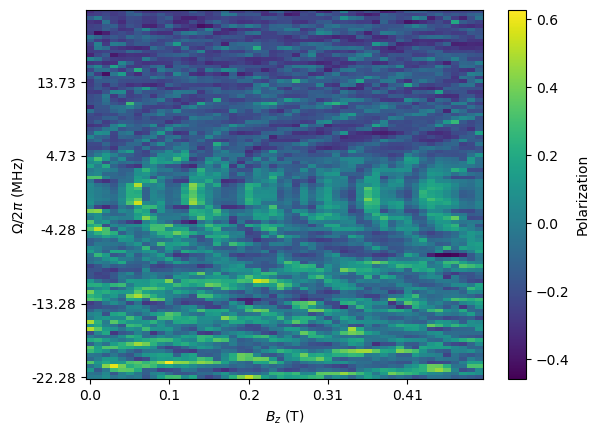

Omega: -128686868.68686868
Bz: 1020.4081632653061


<Figure size 640x480 with 0 Axes>

In [1007]:
plt.imshow(avg_pol,origin='lower',aspect='auto')
#plt.imshow(eigvals,aspect='auto')
plt.xlabel(r"$B_z$ (T)")
plt.ylabel(r"$\Omega/2\pi$ (MHz)")
plt.xticks(np.arange(len(Bz_array), step=int(len(Bz_array)/5)),np.round(Bz_array[0::int(len(Bz_array)/5)]/1e4,2))
plt.yticks(np.arange(len(Omega_array), step=int(len(Omega_array)/5)),np.round(Omega_array[0::int(len(Omega_array)/5)]/(2*np.pi*1e6),2))
plt.colorbar(label="Polarization")
#plt.colorbar(label="Eigenvalue")
plt.show()
plt.clf()

idx = np.unravel_index(np.argmax(avg_pol), avg_pol.shape)
print("Omega: "+str(Omega_array[idx[0]]))
print("Bz: "+str(Bz_array[idx[1]]))

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 927.34it/s]


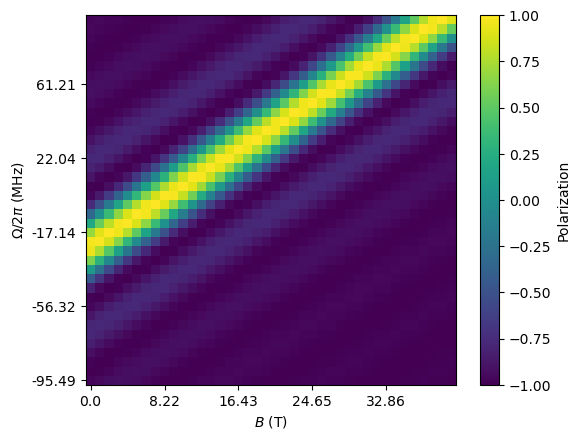

In [426]:
#plot theoretical polarization by time evolving with analytical solution
#so -1*|x1|^2+1*|x2|^2

rho_0 = np.outer(np.array([0,1,0,0]),np.array([0,1,0,0]))

def psi(Omega, omega,t):
    """
    Input: Rabi and Larmor frequencies and time
    Output: relevant state entries at time t
    """
    omega =  omega - (1/2)*Azz_g[0]
    return [0,np.cos((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))+
           1j*(omega-Omega)*np.sin((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))/np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2),
           -2j*np.conjugate(alpha)*np.sin((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))/np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2),0]

t = np.pi/(2*np.abs(alpha))
#t = 5e-7 #test different values, but order of -6 to be >> than A_perp, etc (see paper)
#t_array = (np.pi/np.linspace(0.001,0.5,50))*1e-6

q = 0
B_array = np.array([[i*np.sin(q),0,i*np.cos(q)] for i in np.linspace(0,400500/np.cos(q),40)])
Bz_array = B_array[:,-1]
#Omega_array = gyro_14N*np.linspace(0.001,Bz_array[-1],40)
Omega_array = np.linspace(-600e6,600e6,40)
omega_I_array = Bz_array*gyro_14N
U3 = U1
N = 1

N_g = 0
N_e = 10*N_g
pol = []

#rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.eye(dim_nuc))/dim_nuc
rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.outer(simple_basis.state(1), simple_basis.state(1)))

for Omega in tqdm(Omega_array):
    pol.append([])
    for B in B_array:
#         pol[-1].append(-1*np.abs(psi(Omega,gyro_14N*B[-1],t)[1])**2+1*np.abs(psi(Omega,gyro_14N*B[-1],t)[2])**2)
        rho = np.outer(psi(Omega,gyro_14N*B[-1],t),np.conjugate(psi(Omega,gyro_14N*B[-1],t)))
        pol[-1].append(np.real(np.trace(sum_I_z_g@rho)/(num_nuc*spin_nuc)))
pol = np.array(pol)
plt.imshow(pol,origin='lower',vmin=-1,vmax=1)
plt.xlabel(r"$B$ (T)")
plt.ylabel(r"$\Omega/2\pi$ (MHz)")
plt.xticks(np.arange(len(Bz_array), step=int(len(Bz_array)/5)),np.round(Bz_array[0::int(len(Bz_array)/5)]/1e4,2))
plt.yticks(np.arange(len(Omega_array), step=int(len(Omega_array)/5)),np.round(Omega_array[0::int(len(Omega_array)/5)]/(2*np.pi*1e6),2))
plt.colorbar(label="Polarization")
plt.show()

In [398]:
U1@np.array([0,1,0,0])

array([0.        +0.j, 0.70710678+0.j, 0.        +0.j, 0.70710678+0.j])

In [386]:
psi(Omega,gyro_14N*B[-1],t)

[0,
 (-0.03770169576830243+0.21511270947625827j),
 (0.6900380802383219+0.6900380802383219j),
 0]

In [ ]:
#plot theoretical polarization by time evolving with analytical solution
#here from solution to equation A9

rho_0 = np.outer(np.array([0,1,0,0]),np.array([0,1,0,0]))

def psi(Omega, omega,t):
    """
    Input: Rabi and Larmor frequencies and time
    Output: relevant state entries at time t
    """
    omega = omega - (1/2)*Azz_g[0]
    return [0,np.cos((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))+
           1j*(omega-Omega)*np.sin((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))/np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2),
           -2j*np.conjugate(alpha)*np.sin((1/2)*t*np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2))/np.sqrt((omega-Omega)**2+4*np.abs(alpha)**2)]

t = np.pi/(2*np.abs(alpha))
#t = 5e-7 #test different values, but order of -6 to be >> than A_perp, etc (see paper)
#t_array = (np.pi/np.linspace(0.001,0.5,50))*1e-6

q = 0
B_array = np.array([[i*np.sin(q),0,i*np.cos(q)] for i in np.linspace(0,400500/np.cos(q),40)])
Bz_array = B_array[:,-1]
#Omega_array = gyro_14N*np.linspace(0.001,Bz_array[-1],40)
Omega_array = np.linspace(-600e6,600e6,40)
omega_I_array = Bz_array*gyro_14N
U3 = U1
N = 1

N_g = 0
N_e = 10*N_g
pol = []

#rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.eye(dim_nuc))/dim_nuc
rho_0 = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), np.outer(simple_basis.state(1), simple_basis.state(1)))

for Omega in tqdm(Omega_array):
    pol.append([])
    for B in B_array:
        pol[-1].append(-1*np.abs(psi(Omega,gyro_14N*B[-1],t)[0])**2+1*np.abs(psi(Omega,gyro_14N*B[-1],t)[1])**2)
pol = np.array(pol)
plt.imshow(pol,origin='lower',vmin=-1,vmax=1)
plt.xlabel(r"$\omega_I$ (MHz)")
plt.ylabel(r"$\Omega$ (MHz)")
plt.xticks(np.arange(len(Bz_array), step=int(len(Bz_array)/5)),np.round(Bz_array[0::int(len(Bz_array)/5)]*gyro_14N/1e6,2))
plt.yticks(np.arange(len(Omega_array), step=int(len(Omega_array)/5)),np.round(Omega_array[0::int(len(Omega_array)/5)]/1e6,2))
plt.colorbar(label="Polarization")
plt.show()

In [231]:
np.max(pol)

0.2499958541072608

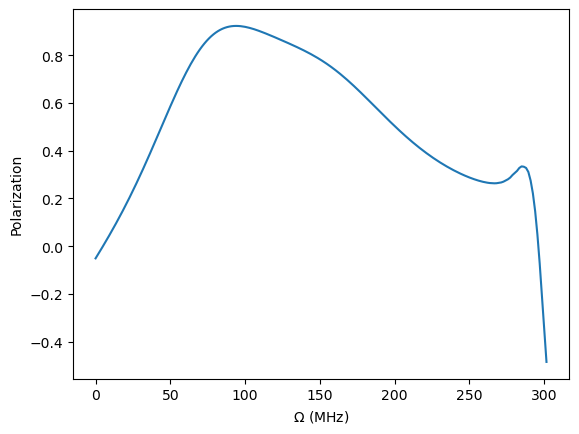

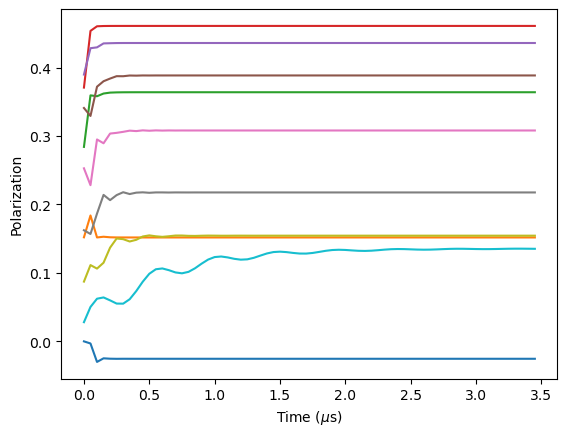

In [433]:
#let's try plotting polarization as a function of pulse time for hartmann-hahn condition

q = 0
B = np.array((np.tan(q),0,1))*Azz_g[0]/(2*gyro_14N)
t = 50e-9   #makes sense, longer the time, more random it becomes, because more time for time evolution

# t = 15/(gyro_14N*B[2])
N=70
N_g = 0
N_e = 10*N_g

Omega_array = gyro_14N*np.linspace(0.001,2*B[-1],200) #hartmann-hahn, equal to larmor frequency, so maximum should be centered 
pol = []
pol_with_time = []

for Omega in Omega_array:
    pol_with_time.append([])
    rho = rho_0
    for i in range(N):
        U2 = scipy.linalg.expm(-1j*H(Omega, B, N_g, N_e)*t) #note the /2 for the rNOVEL sequence
        temp = U3@U2@U1@rho@((U1.T).conjugate())@((U2.T).conjugate())@((U3.T).conjugate())
        rho_I = np.trace(temp.reshape(dim_elec,dim_nuc,dim_elec,dim_nuc), axis1=0, axis2=2)
        rho = np.kron(np.outer(simple_basis.state(0), simple_basis.state(0)), rho_I)
        pol_with_time[-1].append(np.real(np.trace(sum_I_z_g@rho)))
    pol.append(np.real(np.trace(sum_I_z_g@rho))/(num_nuc*spin_nuc))
    #plt.plot(np.arange(len(pol)), pol, label=r"$\Omega=$ "+str(np.round(Omega/1e6,2))+"MHz")

plt.plot(Omega_array/1e6, pol)
plt.xlabel(r"$\Omega$ (MHz)")
plt.ylabel(r"Polarization")
plt.show()

num_plots = 10
for i in range(num_plots):
    plt.plot(np.arange(len(pol_with_time[0]))*t/1e-6, pol_with_time[int(len(pol_with_time)/num_plots*i)])

plt.xlabel(r"Time ($\mu$s)")
plt.ylabel(r"Polarization")
plt.show()
#plt.legend()